In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [30]:
z_dim = 2
batch_size = 100
nb_steps = 150

In [4]:
import os
import tensorflow as tf
isfile = os.path.isfile
join = os.path.join
directory = './chords/'
number_of_files = sum(1 for item in os.listdir(directory) if isfile(join(directory, item)))

In [5]:
!pwd

/Users/sdubnov/Documents/Courses/Mus 206 Deep & Shallow/Notebooks/In progress


In [6]:
import glob
from tqdm import tqdm
import numpy as np
import librosa

def get_chords(path):
    files = glob.glob('{}/*.mp3*'.format(path))
    chords = []
    for f in tqdm(files):
        try:
            #print(f)
            chord = librosa.load(f) 
            #print(f,np.shape(chord[0]))
            if np.array(chord[0]).shape[0] > chord[1]*1:
                chords.append(chord[0][:chord[1]])
                #print(f,  file added')
        except Exception as e:
            raise e           
    return chords

In [7]:
print(number_of_files)
files = glob.glob('{}/*.mp3*'.format(directory))
print(files[0])

301
./chords/piano-chord-Cs5.mp3


In [8]:
chords = get_chords(directory)

100%|██████████| 300/300 [00:32<00:00,  9.12it/s]


In [9]:
#chords = []
#chords.append(chord[0])

np.shape(chords)

(300, 22050)

In [10]:
def render_images(np_x):
    np_x = np_x.reshape((10,10,28,28))
    np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.title('Generation')
    plt.show()

In [11]:
def encoder(x, z_dim=20, reuse=False):
    with tf.variable_scope("encoder", reuse=reuse):
        l1 = tf.layers.dense(x, 512, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(l2, z_dim, activation=None)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(l2, z_dim, activation=None))
        return mu, sigma

In [12]:
def decoder(z, z_dim=20, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        l1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 512, activation=tf.nn.relu)
        x_hat = tf.layers.dense(l2, 22050, activation=tf.nn.sigmoid)
        return x_hat

In [65]:
x = tf.placeholder(tf.float32, [batch_size, 22050])
mu, sigma = encoder(x, z_dim=z_dim)
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
# print(z.shape)
x_hat = decoder(z)

ValueError: Variable encoder/dense/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
  File "/anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/anaconda2/envs/Python37/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)


In [14]:
loglikelihood = tf.reduce_mean(tf.reduce_sum(x * tf.log(x_hat + 1e-8) + (1 - x) * tf.log(1 - x_hat + 1e-8), [1]))
kl = tf.reduce_mean(0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, [1]))
ELBO = loglikelihood - kl
loss = -ELBO

In [15]:
optim_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
init_op = tf.global_variables_initializer()

In [16]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [17]:
#from tensorflow.examples.tutorials.mnist import input_data
#chords = input_data.read_data_sets("./chords/", one_hot=True, reshape=True)

In [35]:
sess.run(init_op)
start_time = time.time()
for stp in range(1, nb_steps+1):
    #x_np, _ = mnist.train.next_batch(batch_size)
    for ind in range(0, len(chords), batch_size): 
        x_np = chords[ind:ind+batch_size]   
        _, loss_np, rec_np, kl_np = sess.run([optim_op, loss, loglikelihood, kl], feed_dict={x: x_np})
        if stp % 10 == 0:
            end_time = time.time()
            print('Step: {:d} in {:.2f}s :: Loss: {:.3f} => Recons.: {:.3f}, KL: {:.3f}'.format(stp, end_time - start_time, loss_np, -rec_np, kl_np))
            start_time = end_time

Step: 10 in 5.02s :: Loss: -2614.429 => Recons.: -2919.413, KL: 304.984
Step: 10 in 0.18s :: Loss: -1696.650 => Recons.: -2002.041, KL: 305.391
Step: 10 in 0.19s :: Loss: -4035.072 => Recons.: -4370.171, KL: 335.099
Step: 20 in 4.98s :: Loss: -4275.083 => Recons.: -4441.725, KL: 166.642
Step: 20 in 0.18s :: Loss: -3246.031 => Recons.: -3424.570, KL: 178.539
Step: 20 in 0.18s :: Loss: -5681.007 => Recons.: -5889.268, KL: 208.260
Step: 30 in 4.95s :: Loss: -4905.475 => Recons.: -5052.327, KL: 146.852
Step: 30 in 0.18s :: Loss: -3993.870 => Recons.: -4159.235, KL: 165.365
Step: 30 in 0.18s :: Loss: -6311.076 => Recons.: -6489.124, KL: 178.048
Step: 40 in 4.92s :: Loss: -5428.011 => Recons.: -5560.960, KL: 132.949
Step: 40 in 0.18s :: Loss: -4714.347 => Recons.: -4871.744, KL: 157.397
Step: 40 in 0.19s :: Loss: -6896.369 => Recons.: -7064.529, KL: 168.160
Step: 50 in 4.97s :: Loss: -5828.992 => Recons.: -5956.810, KL: 127.818
Step: 50 in 0.18s :: Loss: -5199.261 => Recons.: -5350.541, KL: 

In [36]:
total_loss = 0.
total_rec_loss = 0.
n_batches = 0.
zs = []
for i in range(0, 300, batch_size):
    x_np = chords[i:(i+batch_size)]
    z_np, loss_np, rec_np = sess.run([z, loss, loglikelihood], feed_dict={x: x_np})
    total_loss += loss_np
    total_rec_loss += rec_np
    n_batches += 1
    zs.append(z_np)
avg_loss = total_loss/n_batches
avg_rec_loss = total_rec_loss/n_batches
print(avg_loss, -avg_rec_loss)

-7761.304361979167 -7870.030924479167


(300, 2)


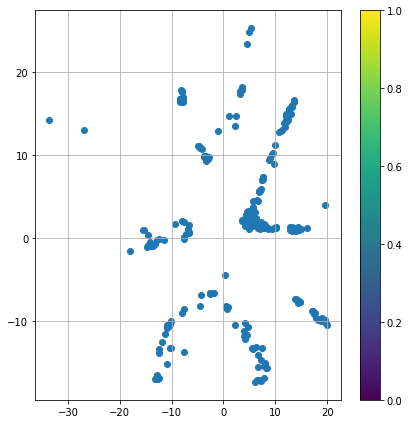

In [55]:
print(np.shape(z_test))
if z_dim == 2:
    z_test = np.vstack(zs)
    #y_test = np.argmax(mnist.test.labels, axis=1)
    plt.figure(figsize=(6, 6))
    plt.scatter(z_test[:, 0], z_test[:, 1])
    #plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, alpha=0.8, cmap='rainbow', edgecolor='k')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('./chords-vae-latentspace.png', dpi=300, bbox_inches='tight')
    plt.grid()

In [101]:
import IPython

# z_new = np.array([[5.0,2.0],],dtype='f')
z_new = np.array([[-9.0,18.0],],dtype='f')
x_hat = decoder(z_new,z_dim=2,reuse=True)

IPython.display.Audio(x_hat.eval(), rate=22050)

In [85]:
z_test[0:1,:]
# [z_new]

array([[9.694972 , 8.9133005]], dtype=float32)

In [93]:
z_new = np.array([[5.0,2.0],],dtype='f')
z_new

array([[5., 2.]], dtype=float32)

In [98]:
x_hat.eval()

array([[1.0132790e-06, 8.6426735e-07, 1.0132790e-06, ..., 6.4818621e-02,
        6.5304771e-02, 5.9103958e-02]], dtype=float32)